In [1]:
import os, sys, time, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Make sure we can import OptIForest from repo
sys.path.append(os.getcwd())
from detectors import OptIForest

SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
def load_creditcard():
    df = pd.read_csv("data/creditcard.csv")

    # Scale the Amount column (important because model is distance-based)
    df["Amount"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1,1))

    # Remove Time (not useful; highly skewed)
    if "Time" in df.columns:
        df = df.drop(columns=["Time"])

    X = df.drop(columns=["Class"]).values
    y = df["Class"].astype(int).values
    return X, y

X, y = load_creditcard()
print("Dataset Loaded:", X.shape, "| Fraud cases:", y.sum())


Dataset Loaded: (284807, 29) | Fraud cases: 492


In [3]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)

print("Train:", X_tr.shape, "Test:", X_te.shape)


Train: (199364, 29) Test: (85443, 29)


In [4]:
def fit_optiforest(X_train, v=3, eps=50, n_estimators=100):
    """
    Fits the OptIForest model with given branching factor (v),
    cut threshold (eps) and number of trees (n_estimators).
    """
    det = OptIForest("L2OPT", n_estimators, eps, v)
    t0 = time.time()
    det.fit(X_train)
    train_time = time.time() - t0
    return det, train_time


def score(det, X_eval):
    """
    Returns anomaly scores + model evaluation time.
    OptIForest returns higher scores for 'normal' points,
    so we invert them (-scores) for anomaly detection metrics.
    """
    t1 = time.time()
    scores = det.decision_function(X_eval)     # higher = normal
    test_time = time.time() - t1
    scores = -scores                           # flip → higher = anomaly
    return scores, test_time


In [5]:
# Define your parameters
v = 3          # branching factor
eps = 50       # cut threshold
n_estimators = 10

det, train_s = fit_optiforest(X_tr, v=v, eps=eps, n_estimators=n_estimators)
scores_te, test_s = score(det, X_te)

auc = roc_auc_score(y_te, scores_te)
ap  = average_precision_score(y_te, scores_te)

print(f"AUC-ROC: {auc:.4f}")
print(f"AUC-PR : {ap:.4f}")
print(f"Train time: {train_s:.3f}s | Test time: {test_s:.3f}s")


AUC-ROC: 0.9342
AUC-PR : 0.1504
Train time: 12.428s | Test time: 51.289s


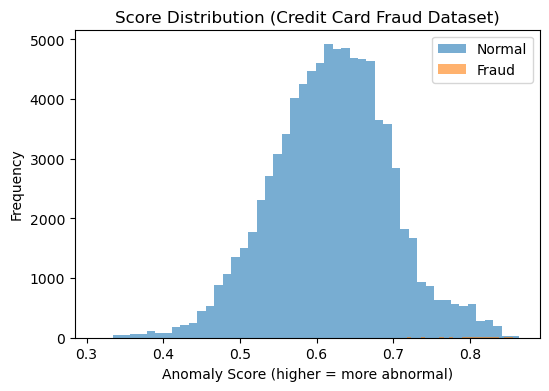

In [6]:
plt.figure(figsize=(6,4))
plt.hist(scores_te[y_te==0], bins=50, alpha=0.6, label="Normal")
plt.hist(scores_te[y_te==1], bins=50, alpha=0.6, label="Fraud")
plt.xlabel("Anomaly Score (higher = more abnormal)")
plt.ylabel("Frequency")
plt.title("Score Distribution (Credit Card Fraud Dataset)")
plt.legend()
plt.show()


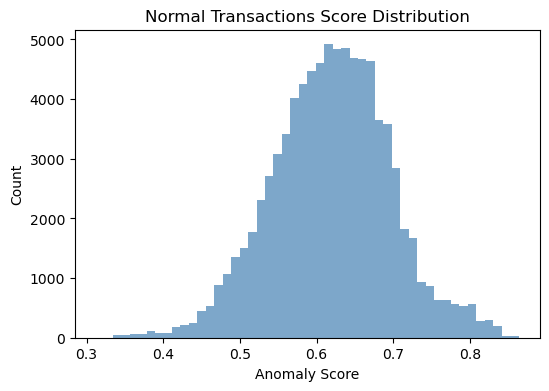

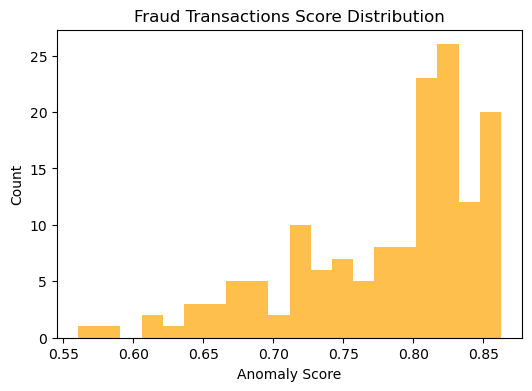

In [10]:
plt.figure(figsize=(6,4))
plt.hist(scores_te[y_te==0], bins=50, alpha=0.7, color='steelblue')
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.title("Normal Transactions Score Distribution")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(scores_te[y_te==1], bins=20, alpha=0.7, color='orange')
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.title("Fraud Transactions Score Distribution")
plt.show()

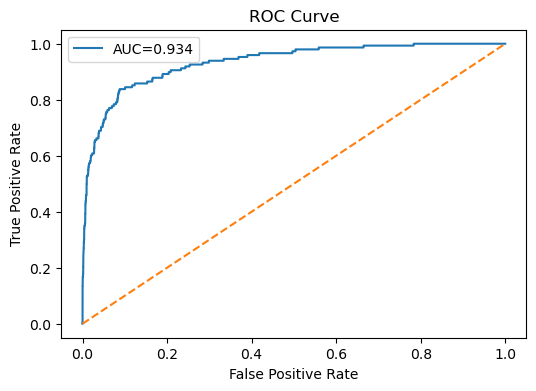

In [7]:
fpr, tpr, thr = roc_curve(y_te, scores_te)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

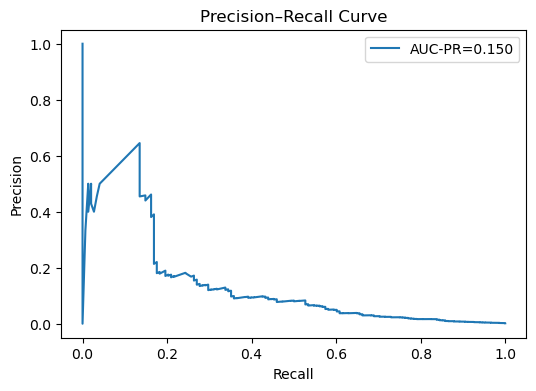

In [8]:
prec, rec, thr = precision_recall_curve(y_te, scores_te)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"AUC-PR={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()
